## NFQ and Acrobot

The [Acrobot](https://gymnasium.farama.org/environments/classic_control/acrobot/) is a classic problem in control theory. The environment consists of two links connected linearly to form a chain, with one end of the chain fixed. The joint between the two links is actuated. The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.

- The Action Space is discrete, deterministic, and represents the torque applied on the actuated joint between the two links: (0) apply -1 torque, (1) apply 0 torque to the actuated joint, (2) apply 1 torque to the actuated joint
- The Observation Space is a 6-dimensional space with the sine anc cosine of the two joint angles and their angular velocities.

1 - import the environment from Gymnasium and show it with a random policy

In [18]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'Acrobot-v1’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium as gym
acrobot = gym.make('Acrobot-v1', render_mode="rgb_array")

2 - Show the policy in action by rendering the environment several times after different decisions from a random policy:

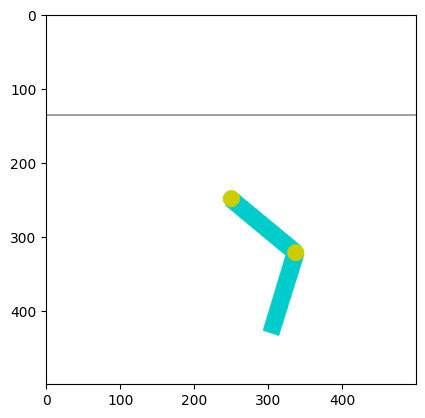

In [19]:
# YOUR CODE HERE

# You can use the same function already used for the cartpole environment

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

def show_policy(env, pi, n_episodes=1, max_steps=500):
    for _ in range(n_episodes):
        state = env.reset()[0]
        done = False
        steps = 0;
        while not done and steps < max_steps:
            if(pi is None):
                action = np.random.choice((0, 1))
            else:
                action = pi.select_action(agent.model, state)
            
            state, reward, done, _, _ = env.step(action)
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            steps += 1
            time.sleep(0.001)

show_policy(acrobot, None)

3 - Create a neural network as a function approximator for the Q-function.

In [7]:
# YOUR CODE HERE

# Add the code for a neural network using the PyTorch library

import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        
        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # creating the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        # connecting the output layer    
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
            
        # pass it through the input layer
        x = self.activation_fc(self.input_layer(x))
        
        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))

        # finally, pass for the output layer
        x = self.output_layer(x)
        
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions)
        new_states = torch.from_numpy(new_states)
        rewards = torch.from_numpy(rewards)
        is_terminals = torch.from_numpy(is_terminals)
        return states, actions, new_states, rewards, is_terminals



4 - Create a the code of two strategy for exploration and exploitation

In [8]:
# YOUR CODE HERE

# Add the code for an exploration strategy based on the epsilon-greedy algorithm

class EGreedyStrategy():
    
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def select_action(self, model, state):
        # pulling out the Q-values for state s
        q_values = model(state).detach()
        # make the values NumPy friendly 
        q_values = q_values.data.numpy().squeeze()

        # get a random number..
        if np.random.rand() > self.epsilon:
            # ...if greater than epsilon, act greedily
            action = np.argmax(q_values)
        else: 
            # ...otherwise, act randomly
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = (action != np.argmax(q_values))
        return action

In [9]:
# YOUR CODE HERE

# Add the code for a exploitation strategy based on the greedy algorithm in order to evaluate your policy

class GreedyStrategy():
    
    def select_action(self, model, state):
        q_values = model(state).detach()
        q_values = q_values.data.numpy().squeeze()
        return np.argmax(q_values)

5 - Write the code of the NFQ algorithm

In [10]:
# YOUR CODE HERE

# Add the code for the NFQ algorithm, with all the needed methods inserted in the class

import random 
import torch
import torch.optim as optim
from itertools import count

class NFQ():
    def __init__(self, env, model, optimizer, train_strategy, eval_strategy,
                 batch_size, epochs):
        self.env = env
        self.seed = seed
        self.model = model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch_size = batch_size
        self.epochs = epochs

    def train(self, gamma, max_minutes, max_episodes, goal_reward):

        # timing variables
        training_start = time.time()

        self.gamma = gamma

        # stats trackers 
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []

        # vector to collect the experience
        self.experiences = []

        result = np.empty((max_episodes, 4))
        result[:] = np.nan
            
        training_time = 0

        # train until we either reach the max minutes, the max episodes or the goal mean reward
        for episode in range(1, max_episodes + 1):

            # get the start time of the episode
            episode_start = time.time()

            # reset the episode trackers
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            # reset the environment before next episode starts
            state, is_terminal = self.env.reset()[0], False
                
            # interact with the environment until the episode is done
            for step in count():

                # interact with environment using the exploration policy
                # and collect the experience batch
                state, is_terminal = self.interaction_step(state)

                # if the experience is enough, then optimize the model 
                if len(self.experiences) >= self.batch_size:

                    # load the experiences as tensors for training
                    experiences = np.array(self.experiences, dtype=object)
                    batches = [np.vstack(sars) for sars in experiences.T]
                    experiences = self.model.load(batches)

                    # optimize the model for a number of epochs
                    for _ in range(self.epochs):
                        self.optimize_model(experiences)
                        
                    # reset the experience batch
                    self.experiences.clear()

                if is_terminal:
                    break
                
            # timing stuff
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            # episode steps count
            total_step = int(np.sum(self.episode_timestep))

            # evaluate the learned policy after the episode
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
                
            # average stats over some recent episodes
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            # report results
            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
                
            # check max episodes, max minutes and goal achievement criteria
            total_elapsed = time.time() - training_start
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
                
            # informative print logging  
            debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
            debug_message = debug_message.format(episode, total_step, mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)

            # conclude training if we have met any of the stopping conditions 
            if training_is_over:
                print(debug_message)
                if reached_max_minutes: print('--> reached_max_minutes ')
                if reached_max_episodes: print('--> reached_max_episodes ')
                if reached_goal_mean_reward: print('--> reached_goal_mean_reward ')
                break
            
        # evaluate the final policy
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
            
        return result, final_eval_score, final_eval_std, training_time
 
    def optimize_model(self, experiences):
        
        # convert the experiences into separate arrays for each element
        states, actions, rewards, next_states, is_terminals = experiences

        # get the batch size
        batch_size = len(is_terminals)
            
        # get the values of the Q-function at next state
        # remember to detach, we need to treat these values as constants 
        q_sp = self.model(next_states).detach()
            
        # get the max value of the next state
        max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
            
        # one important step, often overlooked, is to ensure 
        # terminal states are grounded to zero
        max_a_q_sp *= (1 - is_terminals)
            
        # calculate the target 
        target_q_sa = rewards + self.gamma * max_a_q_sp
            
        # finally, we get the current estimate of Q(s,a)
        q_sa = self.model(states).gather(1, actions)

        # create the errors
        td_errors = q_sa - target_q_sa
            
        # calculate the loss, and optimize the online network
        value_loss = td_errors.pow(2).mul(0.5).mean()

        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()

    def interaction_step(self, state):

        # interact with environment using the exploration policy
        action = self.train_strategy.select_action(self.model, state)

        # collect an experience tuple as usual
        new_state, reward, is_terminal, is_truncated, info = self.env.step(action)
        
        # a failure is defined as follows
        is_failure = is_terminal and not is_truncated

        # collect the experience and store it in the batch 
        experience = (state, action, reward, new_state, float(is_failure))
        self.experiences.append(experience)

        # update episode stats
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        
        return new_state, is_terminal
    
    def evaluate(self, n_episodes=1):

        # create a list of returns of each episode
        rs = []

        # loop over the episodes
        for _ in range(n_episodes):

            # reset the environment
            s = self.env.reset()[0]

            # initialize the return
            rs.append(0)

            # interact with the environment until the episode is done 
            while(True):

                # interact with environment using the exploitation policy
                a = self.eval_strategy.select_action(self.model, s)

                # collect an experience tuple as usual
                s, r, d, t, _ = self.env.step(a)

                # add the reward to the return of the episode
                rs[-1] += r

                if d or t:
                    break
            
        return np.mean(rs), np.std(rs)

6 - Apply NFQ to the acrobot environment. 

In [11]:
# YOUR CODE HERE

# Apply NFQ to the acrobot environment, use a goal_reward of -100 and a gamma of 0.99   

gamma = 0.99

max_minutes = 20
max_episodes = 1000
goal_reward = -100

batch_size = 1024
epochs = 40
seed = 12

# create the environment without the render mode
acrobot = gym.make('Acrobot-v1')

# set the seeds for reproducibility of results
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
acrobot.np_random = np.random.Generator(np.random.PCG64(seed))

print('Training started...')

# create the model, optimizer and strategy
nS, nA = acrobot.observation_space.shape[0], acrobot.action_space.n
model = FCQ(nS, nA, hidden_dims=(512,128))
optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
train_strategy = EGreedyStrategy(epsilon=0.5)
eval_strategy = GreedyStrategy()
    
# create the agent
agent = NFQ(acrobot, model, optimizer, train_strategy, eval_strategy, batch_size, epochs)

# train the agent
result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward)
    
print('...training complete.')

print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))

Training started...
episode 1000, steps 178795, avg eval score -185.0 (+/- 173.8)
--> reached_max_episodes 
...training complete.
Final evaluation score -83.32±12.51 in 37.40s training time



7 - show the learning curves 

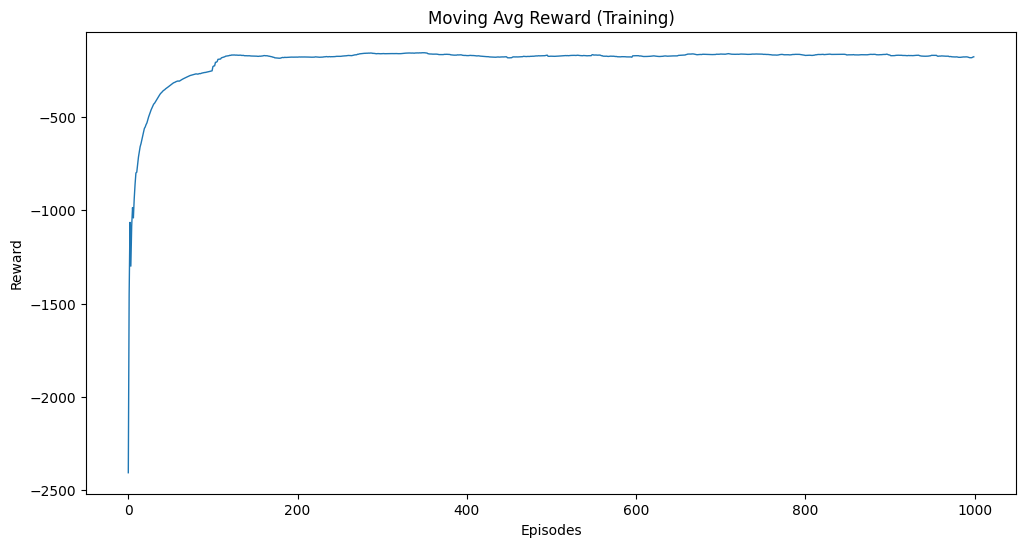

In [17]:
# YOUR CODE HERE

# Show the moving average reward of the training process

import matplotlib.pyplot as plt

steps, train_reward, eval_score, _ = result.T

plt.figure(figsize=(12,6))

plt.plot(train_reward, linewidth=1)
plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

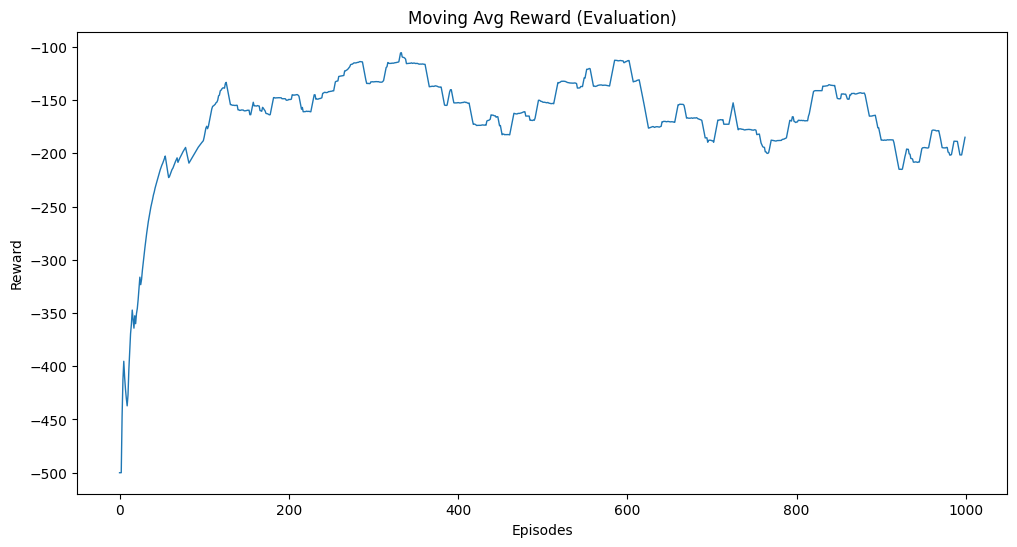

In [15]:
# YOUR CODE HERE

# Show the moving average reward of the evaluation process

plt.figure(figsize=(12,6))

plt.plot(eval_score, linewidth=1)
plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.show()

8 - show the policy behaviour

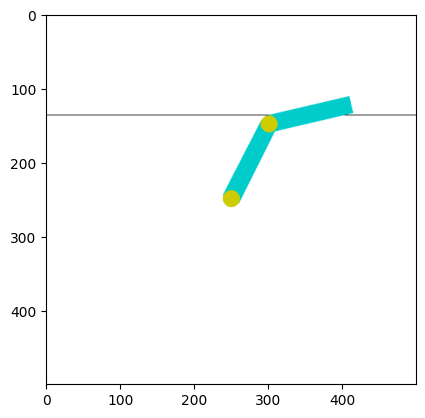

In [20]:
# YOUR CODE HERE

# You can show the policy learned by the agent using the show_policy function

acrobot = gym.make('Acrobot-v1', render_mode="rgb_array")
show_policy(acrobot, agent.eval_strategy, n_episodes=4)